In [1]:
''' 1. Module Import '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.13.1  Device: cpu


In [3]:
BATCH_SIZE = 32
EPOCHS = 1

- 32개의 데이터로 1개의 Mini-Batch 구성
- Iteration: 1개의 Mini-Batch를 이용해 학습하는 횟수
- Epoch: 전체 데이터를 이용해 학습을 진행한 횟수 (하이퍼파라미터)

---

ex: 전체데이터 1만개, BATCH_SIZE=1000
- Iteration = 10,000 / 1,000 = 10

In [4]:
torch.__version__

'1.13.1'

In [5]:
''' 3. MNIST 데이터 다운로드 (Train set, Test set 분리하기) '''
train_dataset = datasets.MNIST(root = "../data/MNIST",
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())

test_dataset = datasets.MNIST(root = "../data/MNIST",
                              train = False,
                              transform = transforms.ToTensor())

# 불러온 데이터 mini-batch 사이즈 단위로 분리해서 지정
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)  # 데이터의 순서 섞는 용도. (label보고 )

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

#### shuffle?
데이터 로더가 각 epoch마다 데이터를 섞을지 여부를 결정.

#### 학습(shuffle = True)
각 미니배치가 다양한 샘플로 구성되어 모델이 더 객관적으로 학습

#### 테스트(shuffle = False)
검증 및 테스트 시에는 모델의 성능을 정확하게 평가하고 비교하기 위해 데이터의 순서를 일정하게 유지하는 것이 중요

In [6]:
''' 4. 데이터 확인하기 (1) '''
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


train) size가 (1, 28, 28) == 채널이 1(흑백) / 픽셀수가 가로x세로 28개씩

test) 32개 데이터 각각에 label값이 하나씩 존재

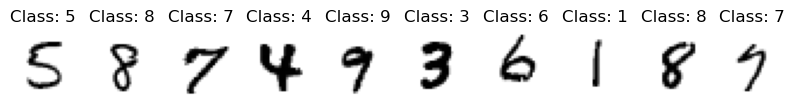

In [7]:
''' 5. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))

In [8]:
''' 6. Multi Layer Perceptron (MLP) 모델 설계하기 '''
class Net(nn.Module):  #nn.Module 클래스 상속받는 Net 클래스 
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)   # Fully Connected Layer의 노드수 512개
        self.fc2 = nn.Linear(512, 256)    # Fully Connected Layer의 노드수 256개 (-> output 노드수 256)
        self.fc3 = nn.Linear(256, 10)   # 10개의 클래스로 분류 (-> output 노드수 10개)
        self.dropout_prob = 0.5   ## DropOut 사용 (drop 비율은 0.5)
        self.batch_norm1 = nn.BatchNorm1d(512)
        self.batch_norm2 = nn.BatchNorm1d(256)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # 2차원 데이터를 1차원으로 펼쳐서 입력받음
        x = self.fc1(x)
        x = self.batch_norm1(x)  # 첫 번째 배치 정규화
        x = F.relu(x)  # 활성화함수 relu 적용
        x = F.dropout(x, training = self.training, p = self.dropout_prob)  # 학습 중에만 dropout 활성화되도록.
        x = self.fc2(x)
        x = self.batch_norm2(x)   # 두 번째 배치 정규화
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)  # 최종 output 계산, 
        return x

##### training=self.training
현재 모델이 훈련 중인지 여부를 나타내는 플래그

- self.training = True : 드롭아웃 활성화
- self.training = False  : 드롭아웃 비활성화

In [9]:
''' 7. Optimizer, Objective Function 설정하기 '''
import torch.nn.init as init
def weight_init(m):  
    if isinstance(m, nn.Linear):  ## MLP를 구성하는 파라미터 중, nn.Linear에 해당하는 값에만 지정
        init.kaiming_uniform_(m.weight.data)   # he_initialization 적용

model = Net().to(DEVICE)  # Net 클래스 인스턴스 생성 및 GPU 이동

model.apply(weight_init)  # 모델 가중치 초기화
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)  # Adam 최적화기 설정
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss 손실 함수 설정

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [10]:
''' 8. MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()   # 모델을 학습 모드로 전환
    for batch_idx, (image, label) in enumerate(train_loader):   # train_loader에서 미니배치를 하나씩 가져와서 학습 수행
        image = image.to(DEVICE)   # 데이터를 GPU로 이동
        label = label.to(DEVICE)
        optimizer.zero_grad()   # 기울기 초기화
        output = model(image)   # 모델에 입력 데이터를 전달하여 출력 계산
        loss = criterion(output, label)  # 손실 함수를 사용하여 예측과 정답 간의 오차 계산
        loss.backward()  # loss값 기반으로 역전파를 통해 기울기 계산
        optimizer.step()  # 파라미터에 할당된 gradient 값을 이용해서 파라미터 값 업데이트

        
        # log_interval 마다 학습 손실 출력
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [11]:
''' 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()  # 모델을 평가 모드로 전환
    # 검증 손실과 정확도 초기화
    test_loss = 0
    correct = 0

    with torch.no_grad():   # 평가할 때에는 값이 업데이트되지 않도록 해당 메소드 사용
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            
            output = model(image)
            
            test_loss += criterion(output, label).item()   # 손실 함수를 사용하여 예측과 정답 간의 오차 계산
            prediction = output.max(1, keepdim = True)[1]   # 모델의 출력에서 가장 높은 값을 가진 클래스의 인덱스를 찾아냄. (확률이 가장 높은 클래스 선택)
            correct += prediction.eq(label.view_as(prediction)).sum().item()  # 정확하게 예측한 개수를 누적
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)  # mini-batch 개수만큼 나눠서 평균 Loss값 계산
    test_accuracy = 100. * correct / len(test_loader.dataset)  #몇 개 맞췄는지 정확도 계산
    return test_loss, test_accuracy

In [12]:
''' 10. MLP 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
for epoch in range(1, EPOCHS + 1):   ## 에폭이 돌아가는 동안 모델 학습
    train(model, train_loader, optimizer, log_interval = 200)  ## MLP, 학습데이터, SGD, 과정 출력
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000 (0%)]	Train Loss: 2.600230
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 0.682045
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 0.182946
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 0.126554
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.126544
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 0.384127
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.250328
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 0.420252
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.567482
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 0.191782

[EPOCH: 1], 	Test Loss: 0.1318, 	Test Accuracy: 95.98 % 



In [13]:
torch.__version__

'1.13.1'

In [14]:
! cat /usr/local/cuda/include/cudnn.h | grep CUDNN_MAJOR -A 2

cat: /usr/local/cuda/include/cudnn.h: No such file or directory


In [15]:
import os
os.getcwd()

'/data2/Sunny/Deep_Learning'

In [16]:
! cd ../../

In [17]:
import torch

# CUDA 사용 가능 여부 확인
cuda_available = torch.cuda.is_available()

if cuda_available:
    # 현재 사용 중인 CUDA 버전 출력
    current_cuda_version = torch.version.cuda
    print(f"CUDA가 사용 가능합니다. 현재 CUDA 버전: {current_cuda_version}")
else:
    print("CUDA를 사용할 수 없습니다.")


CUDA를 사용할 수 없습니다.


In [18]:
# 주피터 노트북에서는 '!'를 사용하여 명령 프롬프트 명령 실행 가능
!where cudnn*

/bin/bash: where: command not found


In [19]:
import torch

# 현재 사용 중인 CUDA 버전 확인
cuda_version = torch.version.cuda
print(f"현재 사용 중인 CUDA 버전: {cuda_version}")

# PyTorch에서 사용 중인 cuDNN 버전 확인
cudnn_version = torch.backends.cudnn.version()
print(f"PyTorch에서 사용 중인 cuDNN 버전: {cudnn_version}")


현재 사용 중인 CUDA 버전: None
PyTorch에서 사용 중인 cuDNN 버전: None


In [20]:
!tar zxvf ../temp/cudnn-10.1-linux-x64-v7.6.5.32.tgz

tar (child): ../temp/cudnn-10.1-linux-x64-v7.6.5.32.tgz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [21]:
pwd()

'/data2/Sunny/Deep_Learning'